In [62]:
import sys
import struct
import array
import numpy

def parse_binary_sig(f):
    sig = f.read(2)

    # '\x00\x42' is NULL followed by a B
    if sig != b'\x00\x42':
        print('unsupported binary format')
        print('expect 0042 but {}'.format(sig.hex()))
        exit(1)

def parse_feat_matrix(f):
    parse_binary_sig(f)

    sig = f.read(3)

    if sig == b'CM ':
        return parse_compressed_matrix(f)
    elif sig == b'FM ':
        return parse_float_matrix(f)
    elif sig == b'DM ':
        return parse_double_matrix(f)
    else:
        print('unsupported matrix format')
        exit(1)
        
def short_to_float(min_value, value_range, value):
    return min_value + value_range * value / 65535.0

def char_to_float(p0, p25, p75, p100, value):
    if value <= 64:
        return p0 + (p25 - p0) * value * (1 / 64)
    elif value <= 192:
        return p25 + (p75 - p25) * (value - 64) * (1 / 128)
    else:
        return p75 + (p100 - p75) * (value - 192) * (1 / 63)

def parse_compressed_matrix(f):
    header = f.read(16)
    min_value, value_range, rows, cols = struct.unpack('<ffii', header)
    result = []

    per_col_header = []
    for i in range(cols):
        s = f.read(8)
        p0, p25, p75, p100 = struct.unpack('<HHHH', s)
        p0 = short_to_float(min_value, value_range, p0)
        p25 = short_to_float(min_value, value_range, p25)
        p75 = short_to_float(min_value, value_range, p75)
        p100 = short_to_float(min_value, value_range, p100)
        per_col_header.append((p0, p25, p75, p100))

    for i in range(cols):
        data = array.array('B')
        data.fromfile(f, rows)
        p0, p25, p75, p100 = per_col_header[i]
        a = [char_to_float(p0, p25, p75, p100, e) for e in data]
        result.extend(a)

    return numpy.array(result).reshape(cols, rows).T

In [63]:
import kaldiark
import numpy as np
from apc import APCModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import librosa
import matplotlib.pyplot as plt
import librosa.display
import cv2
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
m = 1
net = APCModel().to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# save_model_path = './models/final_10context_model.pth'
save_model_path = './models/full_apc_sll.pth'
net.load_state_dict(torch.load(save_model_path))

<All keys matched successfully>

Gradcam start
9.116823196411133
grad shape:  (240, 40)


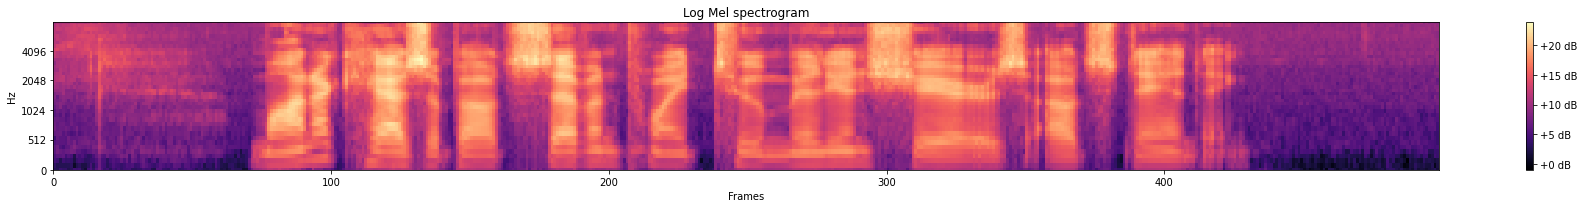

End


In [65]:
norm_path = 'si284-0.9-train.mean-var'

def norm_frame(norm_path):
    norm_file = open(norm_path)
    line1 = np.array(eval(norm_file.readline()))
    line2 = np.array(eval(norm_file.readline()))
    num_samples = int(norm_file.readline())
    mean = line1 / num_samples
    stddev = np.sqrt(line2 / num_samples - mean * mean)
    norm_file.close()
    return mean, stddev
mean, std = norm_frame(norm_path)


def test(d,frame_no):
    print('Gradcam start')
    test_file = open('raw_fbank_train_si284.10.ark', 'rb')
    test_file.seek(d)
    mat = parse_feat_matrix(test_file)
    total_frame = mat.shape[0]
    logmel = mat.T
    mat = (mat - mean) / std
#     print(mat[:200,:].shape)
#     frame_no = 550
    pred = mat[frame_no,:]
    pred = np.expand_dims(pred, axis=0)
    pred = torch.Tensor(pred).to(device)
#     print(pred.shape)
    mat = mat[:frame_no,:]   # 0-199
    mat = np.expand_dims(mat, axis=0)
    mat = torch.Tensor(mat).to(device)
    mat.requires_grad_(True)  # *** if grads True

    out = net(mat)
#     print(out.shape)
    loss = criterion(out[:,-1:,:], pred) * 40
    mat_grad = autograd.grad(loss, mat, retain_graph=True)[0] # ***
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())
    Gradcam(mat_grad, total_frame-frame_no)
    
    logmel
    spec_show(logmel)
      
    return loss.item()

def Gradcam(mat_grad,pad_num):
    # Training Grad-Cam
    mat_cam = torch.squeeze(mat_grad, 0).cpu()
    mat_cam = mat_cam.numpy()
    print("grad shape: ", mat_cam.shape)

    H, W = 2000,200
    cam = np.maximum(mat_cam, 0)
    cam = np.pad(cam, ((0,pad_num),(0,0)),'constant',constant_values=0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (W, H))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
#     cv2.imwrite('mister_gradcam.jpg', heatmap)
#     cv2.imwrite('dapter_gradcam.jpg', heatmap)
#     cv2.imwrite('./3000APC_model/mister_apc.jpg', heatmap)
    cv2.imwrite('test_gradcam.jpg', heatmap)
    
    return mat_cam.shape

def spec_show(logmel):
    plt.figure(figsize=(25, 3))
    librosa.display.specshow(logmel, y_axis='mel', fmax=8000, x_axis='frames')
    # librosa.display.specshow(test_data.T,fmax=8000)

    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel spectrogram')
    plt.tight_layout()
    plt.show()

    
test(12493239,240)
print('End')

Gradcam start
1.450538158416748
grad shape:  (310, 40)


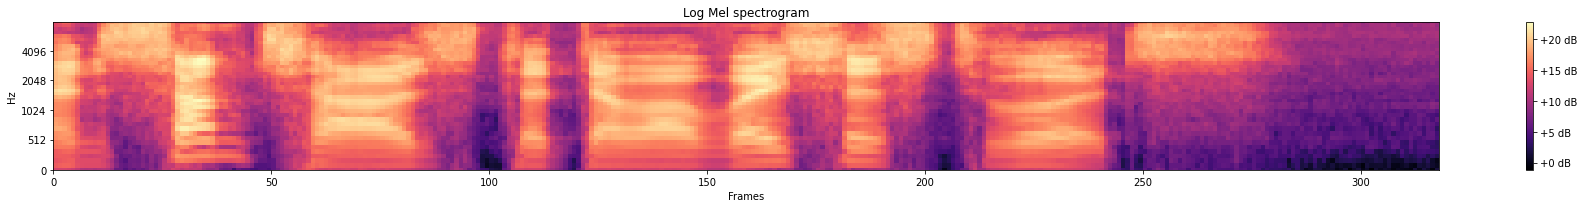

spn spn spn spn spn spn spn spn spn spn spn spn spn spn spn s s s s s s s s s s s s ah ah ah ah ah ah ah ah ah ah m m m m m m m ch ch ch ch ch ch ch ch ch ch ch ch ch ch ch aa aa aa aa aa aa aa aa aa aa aa aa aa aa aa aa aa r r r r r r r r jh jh jh jh jh jh jh jh jh jh jh jh jh jh dh dh dh dh dh dh dh dh dh ah ah ah ah ah ah ah t t t t t t dh dh dh eh eh eh eh r r r aa aa aa aa aa aa aa aa aa aa aa aa aa r r r r r r r r r r r r r r r r r r ey ey ey ey ey ey ey s s s s s s s s s s s s s ih ih ih ih ih ih ih ih ih ih s s s s s s s s s s s s s t t t t t t t t t r r r r r r r r r r r r r uw uw uw uw uw uw uw uw uw uw uw uw uw uw t t t t t t t t s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil
spn spn spn spn spn spn spn spn spn spn spn spn spn spn spn s s s s s s s s s s s s ah ah ah ah ah ah ah ah ah ah m m m m m m m ch ch ch ch ch ch ch 

In [6]:
# 4azc0312 /home/htang2/kaldi/wsj/fbank/raw_fbank_train_si284.10.ark:19983519
test(19983519,310)

bpali_scp_path = 'si284-0.9-dev.bpali.scp'
bpali_path = 'train-si284.bpali'
with open(bpali_scp_path, 'r') as bpali_scp:
    bpali_lines = bpali_scp.readlines()
    for line in bpali_lines:
        file_index = line.split(' ')[0].strip()
        bp_index = line.split(':')[1].strip()
        if file_index == '4azc0312':
#             print(line)
            break

txt_file = open(bpali_path, 'r')
txt_file.seek(int(bp_index))
txt_lines = txt_file.readline().strip()
print(txt_lines) 

txt_list = txt_lines.split(' ')
print(txt_lines)   
print(txt_list[180:200])   
for i in range(300):
    if txt_list[i] == 'uw':
        print(i)

print('End')

Gradcam start
1.3520917892456055
grad shape:  (300, 40)


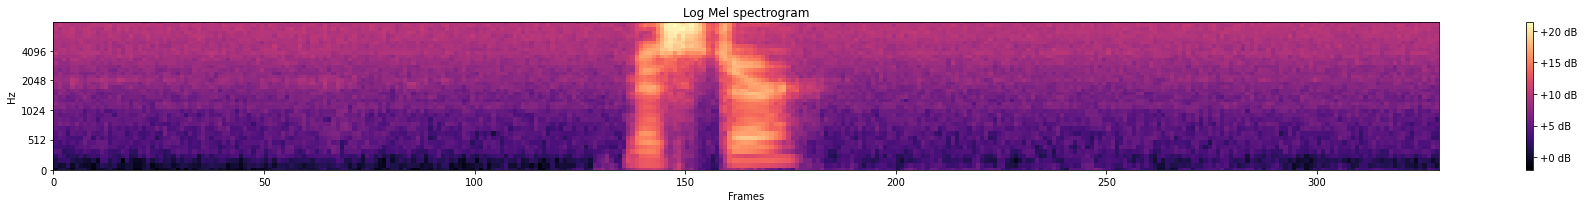

sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil m m m m m m ih ih ih ih ih s s s s s s s s s s s t t t t t t t er er er er er er er er er er er er er er er er er er er er er er er sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil 

In [7]:
# 4b7c030s /home/htang2/kaldi/wsj/fbank/raw_fbank_train_si284.10.ark:53463459


test(53463459,300)
bpali_scp_path = 'si284-0.9-dev.bpali.scp'
bpali_path = 'train-si284.bpali'
with open(bpali_scp_path, 'r') as bpali_scp:
    bpali_lines = bpali_scp.readlines()
    for line in bpali_lines:
        file_index = line.split(' ')[0].strip()
        bp_index = line.split(':')[1].strip()
        if file_index == '4b7c030s':
#             print(line)
            break

txt_file = open(bpali_path, 'r')
txt_file.seek(int(bp_index))
txt_lines = txt_file.readline().strip()

txt_list = txt_lines.split(' ')
print(txt_lines)   
print(txt_list[120:150])   

print('End')

Gradcam start
15.680408477783203
grad shape:  (548, 40)


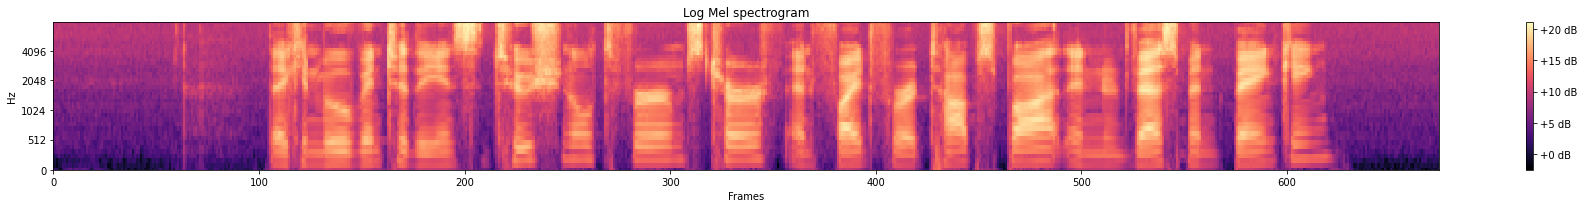

sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil dh dh dh dh dh ey ey ey ey ey ey ey k k k k k k ah ah ah ah ah n n n m m m m m m m uw uw uw uw uw uw uw uw uw v v v v v v v ih ih ih ih n n n n t t t t t t t t t ah ah ah ah dh dh dh dh dh dh dh iy iy iy iy iy iy iy iy iy iy ih ih ih n n n s s s s s s s s s s s t t t ih ih ih t t t t t t t t t t t t uw uw uw uw uw uw uw uw uw sh sh sh sh sh sh sh sh sh sh sh sh ah ah ah ah n n n ah ah ah ah ah ah l l l l l spn spn spn spn spn spn spn spn spn f f f f f f f f f f f er er er er er er er er er er er er er er er er er m m m m m m m m z z z z z z z z t t t t t t t t t t t er er er er er er e

In [68]:
# 4b7c0408 /home/htang2/kaldi/wsj/fbank/raw_fbank_train_si284.10.ark:54293439
test(54293439,548)


bpali_scp_path = 'si284-0.9-dev.bpali.scp'
bpali_path = 'train-si284.bpali'
with open(bpali_scp_path, 'r') as bpali_scp:
    bpali_lines = bpali_scp.readlines()
    for line in bpali_lines:
        file_index = line.split(' ')[0].strip()
        bp_index = line.split(':')[1].strip()
        if file_index == '4b7c0408':
#             print(line)
            break
    

txt_file = open(bpali_path, 'r')
txt_file.seek(int(bp_index))
txt_lines = txt_file.readline().strip()
print(txt_lines)   

txt_list = txt_lines.split(' ')  
print(txt_list[165:175])   
for i in range(630):
    if txt_list[i] == 's':
        print(i)
print('End')

Gradcam start
10.831216812133789
grad shape:  (225, 40)


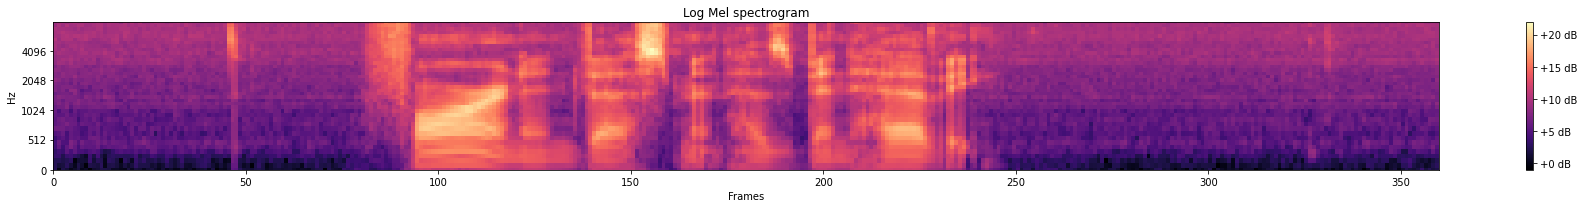

sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil f f f f f f f f f f f f f f f f ao ao ao ao ao ao ao ao ao ao ao r r r r r r r r r r ah ah ah n n n n n ih ih ih ih ih n n n n n n n v v v v v eh eh eh eh eh eh eh eh eh eh s s s s s s s s s s m m m m m m ah ah ah n n n n t t t hh hh hh hh ae ae ae ae ae z z z z z z z b b b b b b ah ah ah ah n n n n hh hh hh hh hh hh hh hh hh hh eh eh eh eh eh eh eh eh eh eh v v v v v v v iy iy iy iy iy iy iy iy iy iy iy iy iy iy iy sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil 

In [72]:
# 4b8c0202 /home/htang2/kaldi/wsj/fbank/raw_fbank_train_si284.10.ark:55561109
test(55561109,225)

bpali_scp_path = 'si284-0.9-dev.bpali.scp'
bpali_path = 'train-si284.bpali'
with open(bpali_scp_path, 'r') as bpali_scp:
    bpali_lines = bpali_scp.readlines()
    for line in bpali_lines:
        file_index = line.split(' ')[0].strip()
        bp_index = line.split(':')[1].strip()
        if file_index == '4b8c0202':
#             print(line)
            break

txt_file = open(bpali_path, 'r')
txt_file.seek(int(bp_index))
txt_lines = txt_file.readline().strip()
print(txt_lines)   

txt_list = txt_lines.split(' ')
   
print(txt_list[165:175])   
for i in range(300):
    if txt_list[i] == 's':
        print(i)
print('End')

Gradcam start
10.940271377563477
grad shape:  (310, 40)


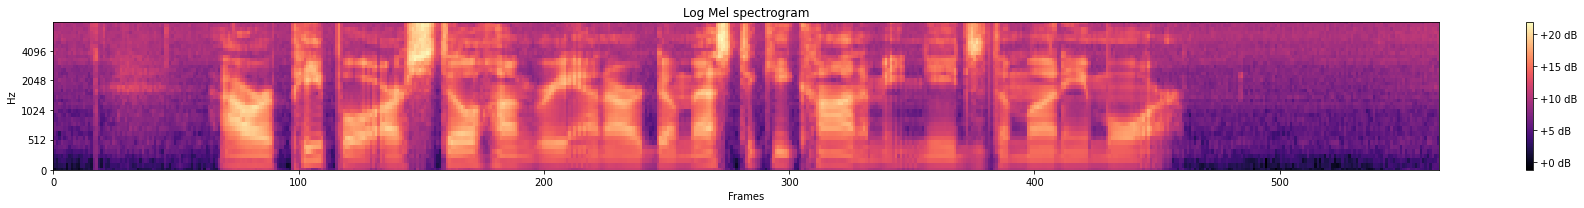

sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw aw er er er er er er er er er p p p p p p p p p p p iy iy iy iy iy iy iy iy iy iy p p p p p p ah ah ah ah ah l l l l l l l l l aa aa aa aa aa aa aa r r r r r r s s s s s s s s s s s t t t t t ih ih ih ih ih l l l l l l l l l hh hh hh hh hh hh hh ah ah ah ah ah ng ng ng ng ng ng ng ng g g g g r r r r r r r iy iy iy iy iy iy ae ae ae ae ae ae ae ae ae n n n d d d aa aa aa aa aa aa aa aa aa r r r r r d d d d d d d d ah ah ah ah ah ah m m m m m m m m eh eh eh eh eh eh eh s s s s s s s s t t t t t t ih ih ih k k k k k k k iy iy iy iy iy iy iy iy k k k k k k k k k k aa aa aa aa aa aa aa aa aa aa aa aa aa aa n n n n ah ah ah m m m m m m m iy iy iy iy iy iy iy iy n n n n n n n n n n iy iy iy iy

In [70]:
# 4b8c020i /home/htang2/kaldi/wsj/fbank/raw_fbank_train_si284.10.ark:56017509

test(56017509, 310)

bpali_scp_path = 'si284-0.9-dev.bpali.scp'
bpali_path = 'train-si284.bpali'
with open(bpali_scp_path, 'r') as bpali_scp:
    bpali_lines = bpali_scp.readlines()
    for line in bpali_lines:
        file_index = line.split(' ')[0].strip()
        bp_index = line.split(':')[1].strip()
        if file_index == '4b8c020i':
#             print(line)
            break

txt_file = open(bpali_path, 'r')
txt_file.seek(int(bp_index))
txt_lines = txt_file.readline().strip()
print(txt_lines)   

txt_list = txt_lines.split(' ') 
print(txt_list[400:430])  
for i in range(550):
    if txt_list[i] == 'k':
        print(i) 


print('End')

Gradcam start
11.298494338989258
grad shape:  (281, 40)


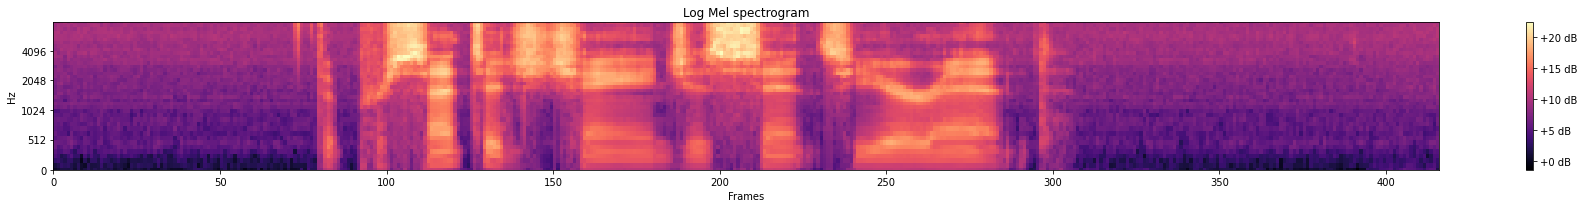

sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil dh dh dh dh dh ah ah ah ah p p p p p p p p p p p er er er er er er s s s s s s s s s s eh eh eh eh eh eh n n n n n t t t t t t t ih ih ih ih ih jh jh jh jh jh jh jh jh jh jh jh jh jh jh ch ch ch ch ch ch ch ch ch ch ey ey ey ey ey ey ey ey ey ey ey ey ey ey ey ey ey ey ey ey ey ey n n n jh jh jh jh jh jh jh jh ih ih ih z z z z z z s s s s s s s s s s s s ih ih ih ih ih ih ih ih ih n n n n n n n n s s s s s s s s y y y y y y y y y ih ih ih ih ih ih ih ih r r r r r r r r r r r eh eh eh eh eh eh eh eh eh eh eh eh eh eh eh eh n n n n n d d d d d d d d d d d d d d d d d d d d d sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil 

In [22]:
# 4b8c020l /home/htang2/kaldi/wsj/fbank/raw_fbank_train_si284.10.ark:56112119
test(56112119,281)#

bpali_scp_path = 'si284-0.9-dev.bpali.scp'
bpali_path = 'train-si284.bpali'
with open(bpali_scp_path, 'r') as bpali_scp:
    bpali_lines = bpali_scp.readlines()
    for line in bpali_lines:
        file_index = line.split(' ')[0].strip()
        bp_index = line.split(':')[1].strip()
        if file_index == '4b8c020l':
#             print(line)
            break

txt_file = open(bpali_path, 'r')
txt_file.seek(int(bp_index))
txt_lines = txt_file.readline().strip()
print(txt_lines)   

txt_list = txt_lines.split(' ')  
print(txt_list[280:320])  
for i in range(400):
    if txt_list[i] == 'p':
        print(i) 


print('End')

# dev loss

In [23]:
norm_path = 'si284-0.9-train.mean-var'

def norm_frame(norm_path):
    norm_file = open(norm_path)
    line1 = np.array(eval(norm_file.readline()))
    line2 = np.array(eval(norm_file.readline()))
    num_samples = int(norm_file.readline())
    mean = line1 / num_samples
    stddev = np.sqrt(line2 / num_samples - mean * mean)
    norm_file.close()
    return mean, stddev
mean, std = norm_frame(norm_path)


def dev_model(dev_path):
    dev_file = open(dev_path, 'r')
    dev_lines = dev_file.readlines()
    dev_loss = 0
    dev_count = 0
    
    for line in dev_lines:
        dev_count += 1
        file_index = line.split(' ')[0].strip() # 011c0201
        line = line.split(' ')[1].strip()

        fbank_path = line.split(':')[0].split('/')[-1]
        fbank_index = line.split(':')[1]
#         print("count:{} utterance index:{}".format(dev_count, fbank_index))

        # utter
        f = open(fbank_path, 'rb')
        f.seek(int(fbank_index))
        mat = kaldiark.parse_feat_matrix(f)
        mat = (mat - mean) / std
#         print(mat)
        
#         print("mat shape: {}".format(mat.shape))
        mat = np.expand_dims(mat, axis=0)
        mat = torch.Tensor(mat).to(device)
#         mat.requires_grad_(True)  # *** if grads True

#         mat_grad = autograd.grad(loss, mat, retain_graph=True)[0] # ***
        out = net(mat)
        loss = criterion(out[:,:-m,:], mat[:,m:,:]) * 40
        if dev_count % 100 == 0:
            print("count:{}, loss:{}".format(dev_count, loss.item()))
        dev_loss += loss.item()

    dev_file.close()
    dev_loss = dev_loss / dev_count
    return dev_loss

    

In [24]:
m = 3
net = APCModel().to(device)
criterion = nn.MSELoss(reduction='mean')

dev_path = 'si284-0.9-dev.fbank.scp'  # 3786

In [26]:
# save_model_path = './models/final_20context.pth'
# save_model_path = './models/final_30context.pth'
# save_model_path = './models/final_40context.pth'
# save_model_path = './models/final_50context.pth'
# save_model_path = './models/final_60context.pth'
# save_model_path = './models/final_70context.pth'
# save_model_path = './models/final_80context.pth'
# save_model_path = './models/final_100context.pth'
# save_model_path = './models/final_120context.pth'
save_model_path = './models/full_apc_sll.pth'
net.load_state_dict(torch.load(save_model_path))
dev_loss = dev_model(dev_path)
print("Final dev loss: ", dev_loss)

In [40]:
save_model_path = './models/final_140context_model.pth'
net.load_state_dict(torch.load(save_model_path))
dev_loss = dev_model(dev_path)
print("Final dev loss: ", dev_loss)

count:100, loss:10.990407943725586
count:200, loss:9.289081573486328
count:300, loss:8.331265449523926
count:400, loss:12.403757095336914
count:500, loss:7.903478145599365
count:600, loss:9.667306900024414
count:700, loss:12.600906372070312
count:800, loss:18.145946502685547
count:900, loss:16.00967025756836
count:1000, loss:7.623282432556152
count:1100, loss:8.036120414733887
count:1200, loss:8.116334915161133
count:1300, loss:11.129007339477539
count:1400, loss:7.23896598815918
count:1500, loss:6.861935138702393
count:1600, loss:9.78022289276123
count:1700, loss:12.018903732299805
count:1800, loss:12.227158546447754
count:1900, loss:10.81222915649414
count:2000, loss:9.433077812194824
count:2100, loss:8.751204490661621
count:2200, loss:12.222421646118164
count:2300, loss:7.9039506912231445
count:2400, loss:8.647008895874023
count:2500, loss:7.4146270751953125
count:2600, loss:7.819311618804932
count:2700, loss:8.104959487915039
count:2800, loss:10.8494291305542
count:2900, loss:10.51